# Create Network of 2m temperature from ERA5


In [7]:
import numpy as np
from climnet.dataset import AnomalyDataset
from climnet.network.net import load, CorrClimNet
from climnet.network.clim_networkx import Clim_NetworkX
from climnet.utils import time_utils
import climnet.plots as cplt

# Set parameters and paths
datapath = '../../data/t2m/2m_temperature_monthly_1979_2020.nc'

### Regridding of data to an equidistant grid

In [2]:
ds = AnomalyDataset(data_nc=datapath, var_name='t2m', grid_step=10,
                    grid_type='fekete', detrend=True, climatology="dayofyear")

['time', 'longitude', 'latitude']
Rename:longitude : lon 
['time', 'lon', 'latitude']
['time', 'lon', 'latitude']
Rename:latitude : lat 
['time', 'lon', 'lat']
Shift longitude!
Start create grid fekete...

Create Fekete grid with 367 points with 1000 iterations.
Initial configuration not provided. Generating random one ...


Estim 54%|████████████████▏             | 538/1000 [00:05<00:05, 91.90it/s] 

convergence reached after 538 iterations!
... Finished
Cut grid in range lat: [array(-90., dtype=float32), array(90., dtype=float32)] and lon: [array(-180., dtype=float32), array(179.75, dtype=float32)]
transpose data!


Interpolate data to new grid:
Detrending data...
... finished!
Compute anomalies for variable t2m.
Created dayofyearly anomalies!


### Create a network from the created dataset

Here we create a network based on spearman correlations where we create the network only for correlation values with highest/lowest correlation such that the density of the network is 2%.

In [3]:
Net = CorrClimNet(ds, corr_method='spearman',
                  density=0.02)
Net.create()

The number of non-zero datapoints 367 should approx. be 367.
(492, 367)
Created spearman correlation matrix of shape (367, 367)
Created spearman correlation matrix of shape (367, 367)
Minimum Correlation values: 0.38823656369239895
Created adjacency matrix.


We remove spurious links using link bundling. This may take a while. Therefore, we suggest to store the network after that.

In [4]:
adjacency_lb = Net.link_bundles(
    num_rand_permutations=2000,
    bw_type='nn'
)
print(f'Density of the network after removing spurious links: {Net.get_sparsity(Net.adjacency)}')
Net.save('../../outputs/t2m_fekete_net_lb.npz')

TypeError: _link_bundles() got an unexpected keyword argument 'bw_type'

Currently, we create a networkx object from the computed network to store computed properties

In [5]:
cnx = Clim_NetworkX(dataset=ds,
                    network=Net,
                    weighted=True)
# Compute node degree
cnx.compute_network_attrs('degree')
# save network as networkx file
cnx.save(savepath='t2m_network.graphml')

100%|██████████| 367/367 [00:00<00:00, 3343.16it/s]

Finished setting edge corr values!
DiGraph with 367 nodes and 2694 edges
Sparsity of adjacency:  0.02000163339248194
Node attributes: ['lon', 'lat']
Edge attributes: ['weight']
Create ds for all attributes present in node 0.
ClimNetworkx File saved to t2m_network.graphml!


### Plot node degree

/home/jakob/Software/anaconda3/envs/climnetenv/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/jakob/Software/anaconda3/envs/climnetenv/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/jakob/Software/anaconda3/envs/climnetenv/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/

{'ax': <GeoAxesSubplot:>,
 'fig': <Figure size 1000x700 with 2 Axes>,
 'projection': <cartopy.crs.PlateCarree at 0x7fbc8f93ad10>,
 'im': <cartopy.mpl.contour.GeoContourSet at 0x7fbc8f937370>}

/home/jakob/Software/anaconda3/envs/climnetenv/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:531: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  elif len(intersection) > 4:
/home/jakob/Software/anaconda3/envs/climnetenv/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:538: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  xy = np.append(intersection[0], intersection[-1],
/home/jakob/Software/anaconda3/envs/climnetenv/lib/python3.9/site-packages/numpy/lib/function_base.py:4739: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = asanyarray(arr)
/home/jakob/Sof

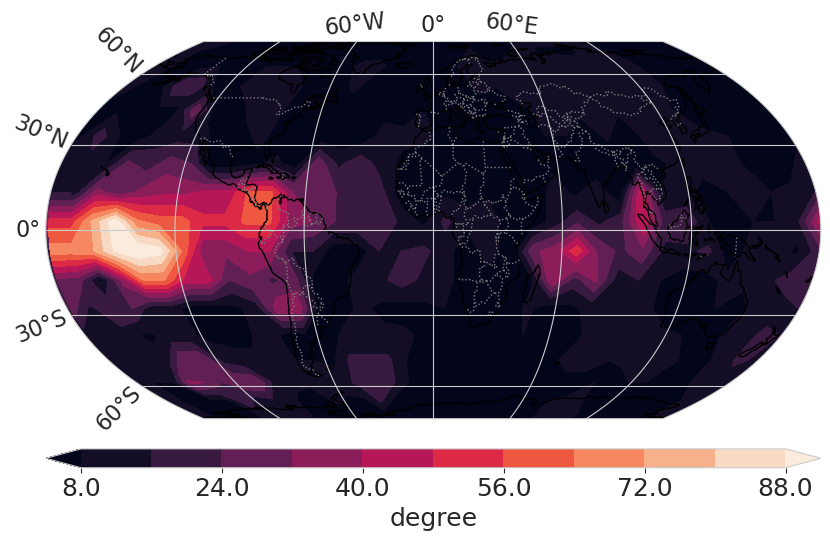

In [8]:
cplt.plot_map(ds, cnx.ds_nx['degree'],
            plot_type='contourf',
            projection='EqualEarth',
            plt_grid=True,
            levels=14,
            tick_step=2,
            round_dec=3)

)